# i3sense Import and process data for small samples of water uptake 0.02 x 0.02 x 0.3

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colormaps
import logging
import scipy.stats as stats
from scipy.signal import savgol_filter
from collections import Counter
from io import StringIO

In [4]:
#!pip install openpyxl

In [5]:
# %cd {"/Documents/01_i3sense/mereni"}

# Experiment

## Load data experiment
excel with two lists referencni and mereni_uzavrene
first row is reference values - beggining at time 15:07 - before some oscilations

In [6]:
#df = pd.read_excel("small_uzavrene.xlsx", sheet_name = None)
df_o = pd.read_excel("small_ohyb_upraveno.xlsx", sheet_name = None)

# check sheet names
#for sheet_name, names in df_o.items():
#    print(f"Sheet name: {sheet_name}")
#    print(names.head())  # or print(df) if you want the full table
#    print("-" * 40)

## Extract list of measured values and plotting

m_orig = {}
m_orig ["beech_open"] = df_o["beech_noninsulated"]
m_orig ["spruce_open"] = df_o["spruce_insulated"]
m_orig ["beech_closed"] = df_o["beech_insulated"]
m_orig ["spruce_closed"] = df_o["spruce_noninsulated"]

#m_orig

In [7]:
col_names   = ['sample 1.1','sample 2.1','sample 3.1','sample 4.1']
col_names_w = ['w1 (-)','w2 (-)','w3 (-)','w4 (-)']

for key, df in m_orig.items():
    # Clean column names (remove stray spaces)
    df.columns = df.columns.str.strip()

    # Make sure Time is numeric hours
    # (decimal=',' should already handle this, but this is safe)
    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")

    # Add Time in seconds
    df["Time (s)"] = df["Time"] * 3600.0

    # Rename T & RH
    df.rename(columns={
        "Temperature": "temp (°C)",
        "Relative Humidity": "RH (%)"
    }, inplace=True)

    # Rename first 4 sample columns to w1..w4 if needed
    df.rename(columns=dict(zip(col_names, col_names_w)), inplace=True)
#m_orig

In [9]:
# 1) Get final time from a reference dataset
final_time = m_orig['beech_closed']['Time (s)'].iloc[-1]

# 2) Create a common time axis (e.g. 200 points evenly spaced)
time_common = np.linspace(0, final_time, 200)  # You can change number of points

# 3) Dictionary to store interpolated data
m_interp = {}

# 4) Interpolate each dataset
for key, df in m_orig.items():
    df_interp = pd.DataFrame({"Time (s)": time_common})

    for col in df.columns:
        if col != "Time (s)":  # avoid interpolating Time column
            df_interp[col] = np.interp(time_common, df["Time (s)"], df[col])

    m_interp[key] = df_interp

#m = m_interp.copy()
m = m_orig.copy()
#m

## Plot beech and spruce all data

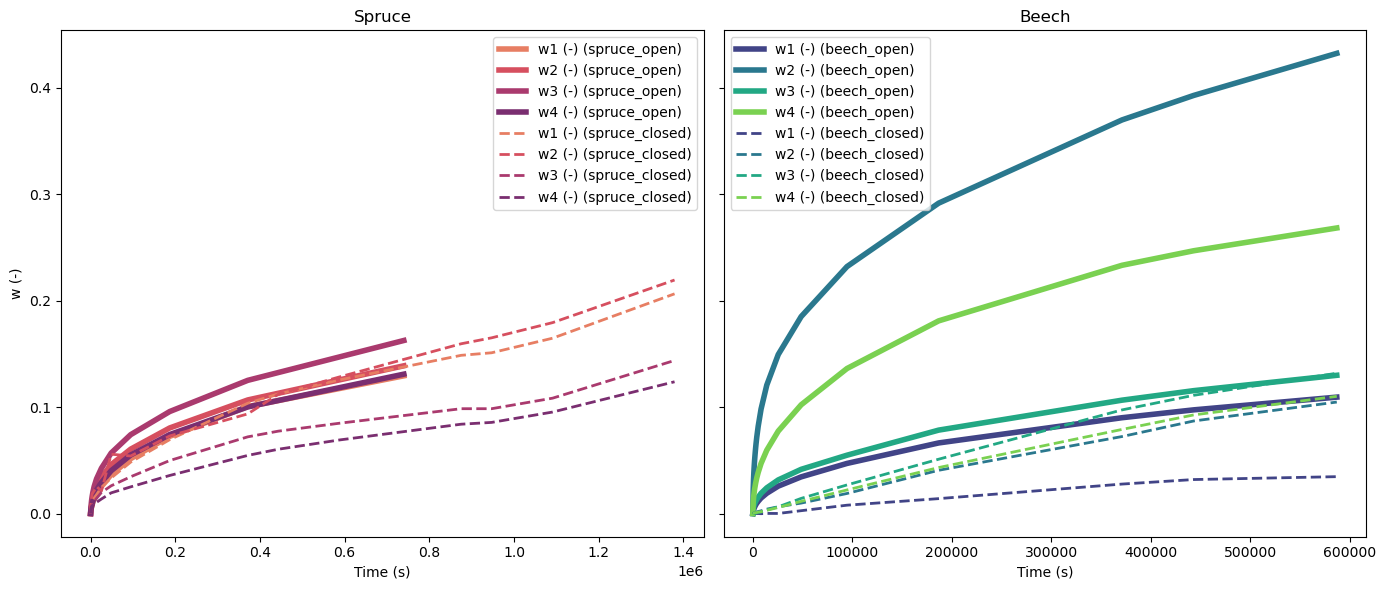

In [10]:
# --- Palettes ---
beech_palette = sns.color_palette("viridis", 4)
spruce_palette = sns.color_palette("flare", 4)

# --- Choose which items to plot (keys in dict m) ---
spruce_keys = ["spruce_open", "spruce_closed"]
beech_keys  = ["beech_open", "beech_closed"]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes = axes.flatten()

# --- Spruce subplot ---
ax = axes[0]
for i, key in enumerate(spruce_keys):
    df = m[key]
    w_cols = col_names_w
    for j, col in enumerate(w_cols):
        ax.plot(
            df["Time (s)"], df[col],
            label=f"{col} ({key})",
            linewidth=4 if "open" in key else 2,
            linestyle="-" if "open" in key else "--",
            color=spruce_palette[j % len(spruce_palette)]
        )
ax.set_title("Spruce")
ax.set_xlabel("Time (s)")
ax.set_ylabel("w (-)")
ax.legend()

# --- Beech subplot ---
ax = axes[1]
for i, key in enumerate(beech_keys):
    df = m[key]
    w_cols = col_names_w
    for j, col in enumerate(w_cols):
        ax.plot(
            df["Time (s)"], df[col],
            label=f"{col} ({key})",
            linewidth=4 if "open" in key else 2,
            linestyle="-" if "open" in key else "--",
            color=beech_palette[j % len(beech_palette)]
        )
ax.set_title("Beech")
ax.set_xlabel("Time (s)")
ax.legend()

plt.tight_layout()
plt.show()


## Calculate median and STD and plot results for selected series

In [11]:
# Create an empty dictionary to store results
m_median = {}

for key, df in m_interp.items():
    m_median[key] = pd.DataFrame({
        'Time (s)': df['Time (s)'],                # add time here
        'median': df[col_names_w].median(axis=1),
        'std': df[col_names_w].std(axis=1)
    })


In [12]:
# Export data
m_median['spruce_open'].to_csv ("spruce_open_ohyb_med.csv",index=False)
m_median['spruce_closed'].to_csv ("spruce_closed_ohyb_med.csv",index=False)
m_median['beech_open'].to_csv ("beech_open_ohyb_med.csv",index=False)
m_median['beech_closed'].to_csv ("beech_closed_ohyb_med.csv",index=False)

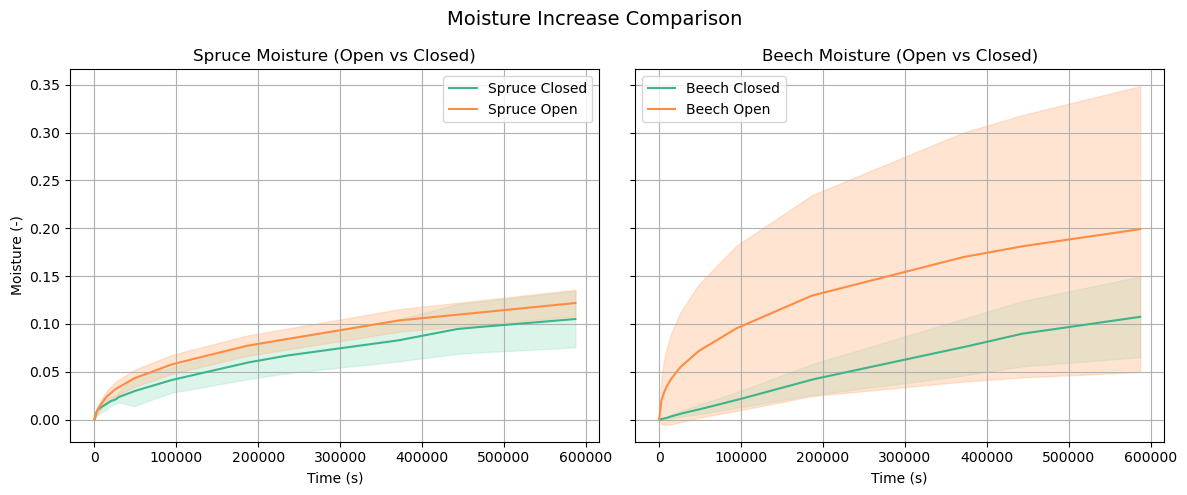

In [13]:
# Styling
mint_line_closed = '#3EB489'   # closed (mint)
mint_fill_closed = '#A8E6CF'   # closed fill
orange_line_open = '#FF8C42'   # open (contrast)
orange_fill_open = '#FFBC8F'   # open fill

# Select data
df_beech_open   = m_median['beech_open']
df_beech_closed = m_median['beech_closed']
df_spruce_open   = m_median['spruce_open']
df_spruce_closed = m_median['spruce_closed']

# Create figure with 2 subplots (Spruce left, Beech right)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# ----------- SPRUCE -----------
axes[0].plot(df_spruce_closed['Time (s)'], df_spruce_closed['median'], label='Spruce Closed', color=mint_line_closed)
axes[0].fill_between(df_spruce_closed['Time (s)'], 
                     df_spruce_closed['median'] - df_spruce_closed['std'], 
                     df_spruce_closed['median'] + df_spruce_closed['std'], 
                     alpha=0.4, color=mint_fill_closed)

axes[0].plot(df_spruce_open['Time (s)'], df_spruce_open['median'], label='Spruce Open', color=orange_line_open)
axes[0].fill_between(df_spruce_open['Time (s)'], 
                     df_spruce_open['median'] - df_spruce_open['std'], 
                     df_spruce_open['median'] + df_spruce_open['std'], 
                     alpha=0.4, color=orange_fill_open)

axes[0].set_title('Spruce Moisture (Open vs Closed)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Moisture (-)')
axes[0].legend()
axes[0].grid(True)

# ----------- BEECH -----------
axes[1].plot(df_beech_closed['Time (s)'], df_beech_closed['median'], label='Beech Closed', color=mint_line_closed)
axes[1].fill_between(df_beech_closed['Time (s)'], 
                     df_beech_closed['median'] - df_beech_closed['std'], 
                     df_beech_closed['median'] + df_beech_closed['std'], 
                     alpha=0.4, color=mint_fill_closed)

axes[1].plot(df_beech_open['Time (s)'], df_beech_open['median'], label='Beech Open', color=orange_line_open)
axes[1].fill_between(df_beech_open['Time (s)'], 
                     df_beech_open['median'] - df_beech_open['std'], 
                     df_beech_open['median'] + df_beech_open['std'], 
                     alpha=0.4, color=orange_fill_open)

axes[1].set_title('Beech Moisture (Open vs Closed)')
axes[1].set_xlabel('Time (s)')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Moisture Increase Comparison', fontsize=14)
plt.tight_layout()
plt.show()


## COMSOL validation

In [17]:
# Read the text file
df_spruce_valid = pd.read_csv(
    "spruce_closed_open_open2000.txt",     # path of the uploaded file
    sep=r"\s+",             # split by ANY whitespace
    skiprows=5,             # skip COMSOL header metadata
    header = None
    #names=["Time (s)", "c_b (1)", "c_b_first (1)"]  # rename columns
)
#df_spruce_valid

In [20]:
spruce_cm = {}  # outer dict

# --- CLOSED ---
spruce_cm['closed'] = {}  # create nested dict FIRST
spruce_cm['closed']['Time (s)'] = df_spruce_valid.iloc[:, 0].copy()
spruce_cm['closed']['w (-)'] = df_spruce_valid.iloc[:, 1].copy()
spruce_cm['closed']['w_rel (-)'] = df_spruce_valid.iloc[:, 2].copy()

# --- OPEN ---
spruce_cm['open'] = {}  # create nested dict FIRST
spruce_cm['open']['Time (s)'] = df_spruce_valid.iloc[:, 0].copy()
spruce_cm['open']['w (-)'] = df_spruce_valid.iloc[:, 5].copy()
spruce_cm['open']['w_rel (-)'] = df_spruce_valid.iloc[:, 6].copy()

spruce_df = {
    'closed': pd.DataFrame(spruce_cm['closed']),
    'open':   pd.DataFrame(spruce_cm['open'])
}

# preview both:
for key, df in spruce_df.items():
    print(f"\n--- {key} ---")
    print(df.head())


--- closed ---
   Time (s)     w (-)  w_rel (-)
0       0.0  0.100979   0.000000
1    5871.6  0.110687   0.009708
2   11743.2  0.115125   0.014146
3   17614.8  0.118537   0.017557
4   23486.4  0.121420   0.020440

--- open ---
   Time (s)     w (-)  w_rel (-)
0       0.0  0.101027   0.000000
1    5871.6  0.113460   0.012433
2   11743.2  0.119212   0.018184
3   17614.8  0.123566   0.022538
4   23486.4  0.127476   0.026449


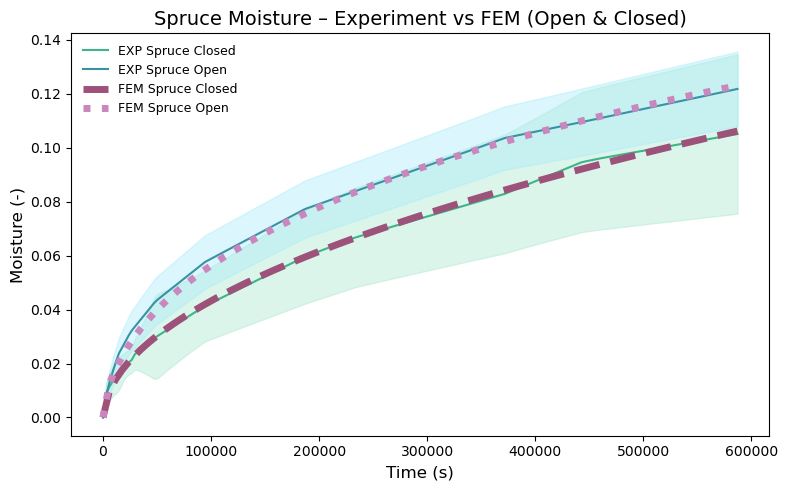

In [21]:
import matplotlib.pyplot as plt

# Colors
mint_line_closed = '#3EB489'   # EXP closed (mint)
mint_fill_closed = '#A8E6CF'   # EXP closed fill
blue_line_open = '#3992A3'   # EXP open (orange)
blue_fill_open = '#A5ECFA'   # EXP open fill
pink_line_fem_o    = '#C987BD'   # FEM (COMSOL) curves
pink_line_fem_c    = '#9C5279'   # FEM (COMSOL) curves

# Experimental median/std (already in m_median)
df_spruce_open   = m_median['spruce_open']
df_spruce_closed = m_median['spruce_closed']

fig, ax = plt.subplots(figsize=(8, 5))

# ----------- EXPERIMENTAL SPRUCE -----------
# Closed
ax.plot(
    df_spruce_closed['Time (s)'],
    df_spruce_closed['median'],
    label='EXP Spruce Closed',
    color=mint_line_closed
)
ax.fill_between(
    df_spruce_closed['Time (s)'],
    df_spruce_closed['median'] - df_spruce_closed['std'],
    df_spruce_closed['median'] + df_spruce_closed['std'],
    alpha=0.4,
    color=mint_fill_closed
)

# Open
ax.plot(
    df_spruce_open['Time (s)'],
    df_spruce_open['median'],
    label='EXP Spruce Open',
    color=blue_line_open
)
ax.fill_between(
    df_spruce_open['Time (s)'],
    df_spruce_open['median'] - df_spruce_open['std'],
    df_spruce_open['median'] + df_spruce_open['std'],
    alpha=0.4,
    color=blue_fill_open
)

# ----------- FEM SPRUCE (from spruce_df) -----------
# Closed FEM
ax.plot(
    spruce_df['closed']['Time (s)'],
    spruce_df['closed']['w_rel (-)'],
    label='FEM Spruce Closed',
    color=pink_line_fem_c,
    linestyle='--',
    linewidth=5
)

# Open FEM
ax.plot(
    spruce_df['open']['Time (s)'],
    spruce_df['open']['w_rel (-)'],
    label='FEM Spruce Open',
    color=pink_line_fem_o,
    linestyle=':',
    linewidth=5
)

# Formatting
ax.set_title('Spruce Moisture – Experiment vs FEM (Open & Closed)', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Moisture (-)', fontsize=12)
ax.grid(False)
ax.legend(fontsize=9,frameon=False)
plt.tight_layout()
plt.show()

fig.savefig('spruce_valid_bend.png', dpi=300, bbox_inches="tight")

## ANSYS validation

In [26]:
ansys = {}

In [27]:
df_a = pd.read_csv('time__vs__avg_mc_225_u_sm_long_open_600.txt',header = None)
#df_a

In [28]:
mc = 'mc_sm_long_open_600'
ansys [mc]= df_a.copy()
# Extract time from column 0
ansys[mc]['time'] = df_a.iloc[:, 0]       # first column

# Extract moisture from column 2 → convert to fraction
ansys[mc]['w'] = df_a.iloc[:, 2] / 100    # convert (%) to (-)
#ansys

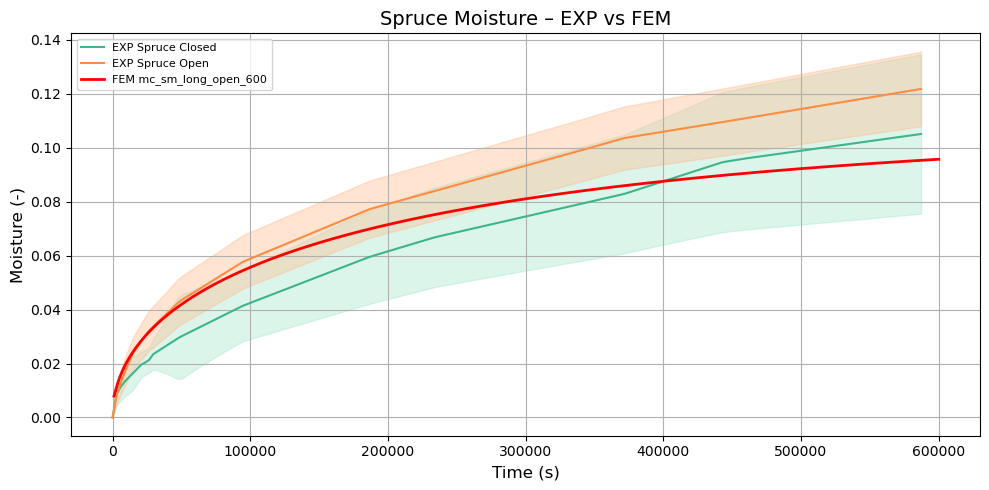

In [29]:
## Plot 
# --- Colors ---
mint_line_closed = '#3EB489'   # closed (mint)
mint_fill_closed = '#A8E6CF'   # closed fill
orange_line_open = '#FF8C42'   # open (contrast)
orange_fill_open = '#FFBC8F'   # open fill
pink_line_sp = '#C987BD'       # FEM curves

# Create figure (single axis)
fig, ax_sp = plt.subplots(figsize=(10, 5))

# ----------- EXPERIMENTAL SPRUCE (OPEN & CLOSED) -----------
ax_sp.plot(df_spruce_closed['Time (s)'], df_spruce_closed['median'],
           label='EXP Spruce Closed', color=mint_line_closed)
ax_sp.fill_between(df_spruce_closed['Time (s)'],
                   df_spruce_closed['median'] - df_spruce_closed['std'],
                   df_spruce_closed['median'] + df_spruce_closed['std'],
                   alpha=0.4, color=mint_fill_closed)

ax_sp.plot(df_spruce_open['Time (s)'], df_spruce_open['median'],
           label='EXP Spruce Open', color=orange_line_open)
ax_sp.fill_between(df_spruce_open['Time (s)'],
                   df_spruce_open['median'] - df_spruce_open['std'],
                   df_spruce_open['median'] + df_spruce_open['std'],
                   alpha=0.4, color=orange_fill_open)

# ----------- FEM / ANSYS CURVES -----------
for name, df in ansys.items():
    # 🔍 CHECK your column names (example expects 'time' and 'w')
    ax_sp.plot(df['time'], df['w'], label=f'FEM {name}', linewidth=2, color = 'red')

# ----------- LABELING -----------
ax_sp.set_title('Spruce Moisture – EXP vs FEM', fontsize=14)
ax_sp.set_xlabel('Time (s)', fontsize=12)
ax_sp.set_ylabel('Moisture (-)', fontsize=12)
ax_sp.grid(True)
ax_sp.legend(fontsize=8)
plt.tight_layout()
plt.show()


# Optimization comsol - old
## Prepare model data and find best fit

In [ ]:
# =========================
# CONFIG
# =========================
PARAM_COMS_PATH = "param_coms.csv"   # your model file (.txt/.csv)
SKIP_FIRST_ROWS = 4
TARGET_SPECIES  = "spruce"                      # "spruce" or "beech"
SHOW_MODEL_MARKERS = False                     # True to show markers on model
PALETTE_MODELS = "tab10"                       # colors for multiple models
SPECIES_PALETTE = "Set2"                       # species colors (beech/spruce)

# =========================
# HELPERS
# =========================
def find_time_col(df):
    """Prefer a column that looks like time; else first column."""
    lower = {str(c).lower(): c for c in df.columns}
    for key in ["time (s)", "time_s", "time", "t", "timestamp"]:
        if key in lower:
            return lower[key]
    return df.columns[0]

def rmse_masked(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 2:
        return np.inf
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask])**2)))

def prepare_models(models, time_col):
    """
    Deduplicate by time (mean), sort, and keep only numeric-ready columns.
    Returns: dict col_name -> tidy DataFrame [time_col, col_name]
    """
    prepared = {}
    for col in models.columns:
        if col == time_col:
            continue
        tmp = models[[time_col, col]].dropna()
        if tmp.shape[0] < 2:
            continue
        tmp = tmp.groupby(time_col, as_index=False).mean().sort_values(time_col)
        prepared[col] = tmp
    return prepared

def score_models(prepared, time_col, t_exp, y_true):
    """Interpolate each model to experiment times (inside range) and compute RMSE."""
    scores = []
    for col, tmp in prepared.items():
        t_m = tmp[time_col].to_numpy(dtype=float)
        y_m = tmp[col].to_numpy(dtype=float)
        inside = (t_exp >= t_m.min()) & (t_exp <= t_m.max())
        if inside.sum() < 2:
            continue
        y_pred = np.interp(t_exp[inside], t_m, y_m)
        r = rmse_masked(y_true[inside], y_pred)
        scores.append((col, r))
    scores_sorted = sorted(scores, key=lambda x: x[1])
    return scores_sorted

def species_colors(palette_name=SPECIES_PALETTE):
    cmap = colormaps.get(palette_name)
    return cmap(0), cmap(1)  # (beech, spruce)

def plot_experiment(ax, exp_series, species="beech"):
    beech_c, spruce_c = species_colors()
    species_color = spruce_c if species.lower() == "spruce" else beech_c
    ax.plot(
        exp_series["Time (s)"], exp_series["w_med"],
        linewidth=3, linestyle="--", color=species_color,
        label=f"{species.capitalize()} (median)"
    )
    ax.fill_between(
        exp_series["Time (s)"],
        exp_series["w_med"] - exp_series["w_band"],
        exp_series["w_med"] + exp_series["w_band"],
        color=species_color, alpha=0.25,
        label=f"{species.capitalize()} band"
    )
    return species_color

def plot_models_lines(
    ax, prepared, time_col, cols, colors=None, linewidth=2, markers=False, label_fmt="{name} (RMSE={rmse:.3g})", rmse_map=None
):
    for i, name in enumerate(cols):
        tmp = prepared[name]
        color = (colors[i] if (colors is not None and i < len(colors)) else None)
        if markers:
            me = max(1, len(tmp)//800)
            ax.plot(tmp[time_col], tmp[name],
                    linewidth=linewidth, linestyle="-", color=color,
                    marker="o", markersize=3, markevery=me,
                    label=label_fmt.format(name=name, rmse=rmse_map.get(name, np.nan) if rmse_map else np.nan))
        else:
            ax.plot(tmp[time_col], tmp[name],
                    linewidth=linewidth, linestyle="-", color=color,
                    label=label_fmt.format(name=name, rmse=rmse_map.get(name, np.nan) if rmse_map else np.nan))

def plot_models_background(ax, models, time_col, color="gray", alpha=0.25, lw=0.8):
    for col in models.columns:
        if col == time_col:
            continue
        tmp = models[[time_col, col]].dropna()
        if tmp.shape[0] < 2:
            continue
        tmp = tmp.groupby(time_col, as_index=False).mean().sort_values(time_col)
        ax.plot(tmp[time_col], tmp[col], linewidth=lw, alpha=alpha, color=color)

In [ ]:
# =========================
# LOAD & PREP DATA
# (Assumes you already built: beech_series, spruce_series)
# =========================
models = pd.read_csv(PARAM_COMS_PATH, sep=None, engine="python", skiprows=SKIP_FIRST_ROWS, on_bad_lines="skip")

time_col = find_time_col(models)
models[time_col] = pd.to_numeric(models[time_col], errors="coerce")
for c in models.columns:
    if c == time_col: 
        continue
    models[c] = pd.to_numeric(models[c], errors="coerce")
models = models.dropna(subset=[time_col]).sort_values(time_col)

exp_series = spruce_series if TARGET_SPECIES.lower() == "spruce" else beech_series
t_exp = exp_series["Time (s)"].to_numpy(dtype=float)
y_true = exp_series["w_med"].to_numpy(dtype=float)

prepared = prepare_models(models, time_col)
scores_sorted = score_models(prepared, time_col, t_exp, y_true)
if not scores_sorted:
    raise RuntimeError("No model columns could be scored (check your model file).")

# Best + Top-K
best_name, best_rmse = scores_sorted[0]
topk = scores_sorted[:min(3, len(scores_sorted))]  # K=3 by default
rmse_map = {name: rmse for name, rmse in scores_sorted}

In [ ]:
# =========================
# FIGURE A: Experiment vs BEST model
# =========================
figA, axA = plt.subplots(figsize=(10, 6), constrained_layout=True)
species_color = plot_experiment(axA, exp_series, species=TARGET_SPECIES)

# Best model (native grid)
plot_models_lines(
    axA, prepared, time_col, [best_name],
    colors=["black"], linewidth=2.5, markers=SHOW_MODEL_MARKERS,
    label_fmt="Best model: {name} (RMSE={rmse:.3g})",
    rmse_map=rmse_map
)

axA.set_title(f"{TARGET_SPECIES.capitalize()} vs Best-Fit Model (native grid)")
axA.set_xlabel("Time (s)")
axA.set_ylabel("w (-)")
axA.grid(alpha=0.3)
axA.legend(frameon=False, loc="best")
figA.savefig(f"{TARGET_SPECIES}_vs_best_model.png", dpi=300, bbox_inches="tight")

# =========================
# FIGURE B: Experiment vs TOP-3 models
# =========================
figB, axB = plt.subplots(figsize=(10, 6), constrained_layout=True)
species_color = plot_experiment(axB, exp_series, species=TARGET_SPECIES)

# top-K colors
model_cmap = colormaps.get(PALETTE_MODELS)
top_names = [n for n, _ in topk]
top_colors = [model_cmap(i % 10) for i in range(len(top_names))]

plot_models_lines(
    axB, prepared, time_col, top_names,
    colors=top_colors, linewidth=2, markers=False,
    label_fmt="{name} (RMSE={rmse:.3g})",
    rmse_map=rmse_map
)

axB.set_title(f"{TARGET_SPECIES.capitalize()} vs Top-{len(top_names)} Best Models")
axB.set_xlabel("Time (s)")
axB.set_ylabel("w (-)")
axB.grid(alpha=0.3)
axB.legend(frameon=False, loc="best")

# =========================
# FIGURE C: ALL models thin + highlight BEST
# =========================
figC, axC = plt.subplots(figsize=(10, 6), constrained_layout=True)

# background all models
plot_models_background(axC, models, time_col, color="gray", alpha=0.25, lw=0.8)

# highlight best (manual legend text if you like)
manual_best_label = None  # e.g. "Best: P_cons 4*38000, D_L 1e-8, D_T 1e-9"
best_label = manual_best_label or f"Best model: {best_name} (RMSE={best_rmse:.3g})"

plot_models_lines(
    axC, prepared, time_col, [best_name],
    colors=["black"], linewidth=2.5, markers=False,
    label_fmt=best_label.replace("{name}", best_name).replace("{rmse}", f"{best_rmse:.3g}"),
    rmse_map=None  # label already formatted
)

# experiment on top
plot_experiment(axC, exp_series, species=TARGET_SPECIES)

axC.set_title(f"All Models vs {TARGET_SPECIES.capitalize()} (Best highlighted)")
axC.set_xlabel("Time (s)")
axC.set_ylabel("w (-)")
axC.grid(alpha=0.3)
axC.legend(frameon=False, loc="best")
figC.savefig(f"{TARGET_SPECIES}_vs_best_model_all.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# =========================
# ERROR ANALYSIS for the best model (vs spruce median)
# =========================
# Residuals: model - experiment
residual = common[best_model_name] - common["w_med"]
abs_error = residual.abs()
sq_error = residual**2
best_rmse_check = float(np.sqrt(np.mean(sq_error)))  # should match best_rmse

print(f"Best model: {best_model_name}")
print(f"RMSE (recomputed): {best_rmse_check:.6g}")
print(f"Mean absolute error: {abs_error.mean():.6g}")
print(f"Max absolute error:  {abs_error.max():.6g}")

# FIGURE 3: Residuals over time
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(common["Time (s)"], residual, linewidth=1.5, label="Residual (model - spruce)")
ax.axhline(0, linewidth=1)
ax.set_title(f"Residuals vs Time — {best_model_name} (RMSE={best_rmse_check:.4g})")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Residual")
ax.grid(alpha=0.3)
ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

# FIGURE 4: Absolute error over time (optional but useful)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(common["Time (s)"], abs_error, linewidth=1.5, label="|Residual|")
ax.set_title(f"Absolute Error vs Time — {best_model_name}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("|Residual|")
ax.grid(alpha=0.3)
ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

# RVD (EMC) for boundary conditions

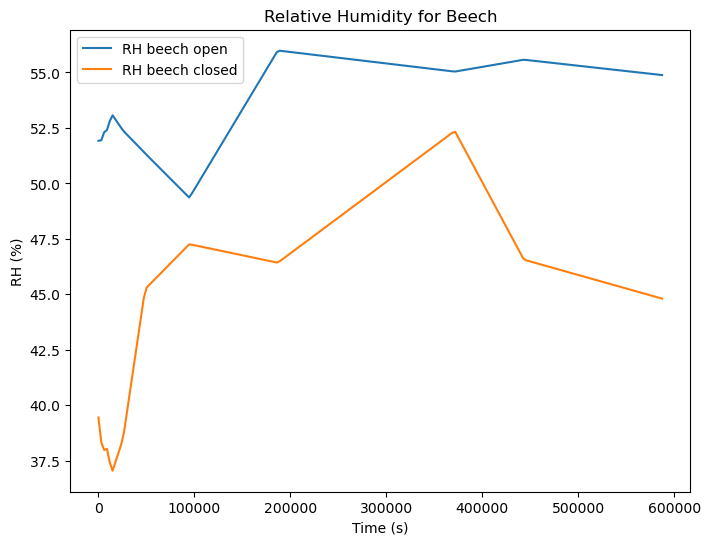

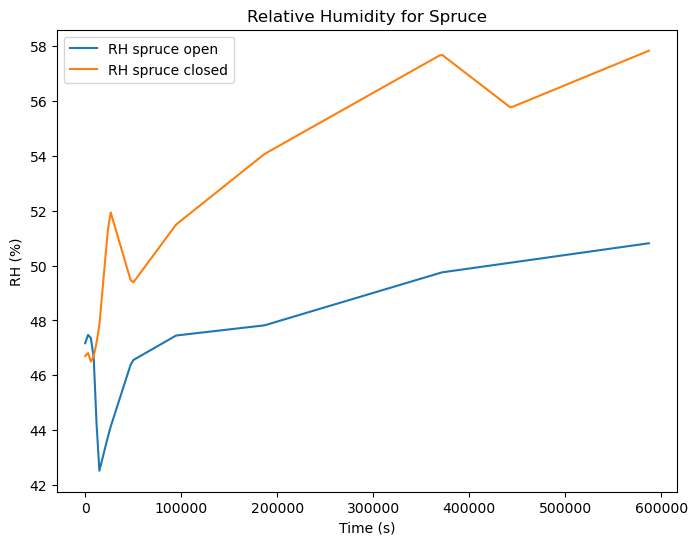

{'beech_open': 52.52447218762633, 'beech_closed': 40.546340476344476, 'spruce_open': 47.3362523328567, 'spruce_closed': 49.72631016501793}


In [15]:
## Relative humidity

for wood in ["beech", "spruce"]:
    plt.figure(figsize=(8,6))  # one figure per wood type
    
    for state in ["open", "closed"]:
        key = f"{wood}_{state}"
        plt.plot(m_interp[key]["Time (s)"], m_interp[key]["RH (%)"], label=f"RH {key.replace('_', ' ')}")
    
    plt.xlabel("Time (s)")
    plt.ylabel("RH (%)")
    plt.legend()
    plt.title(f"Relative Humidity for {wood.capitalize()}")
    plt.show()

RH_avg = {}  # empty dictionary

for wood in ["beech", "spruce"]:
    for state in ["open", "closed"]:
        key = f"{wood}_{state}"
        RH_avg[key] = m[key]['RH (%)'].mean()
        
print(RH_avg)


## EMC for comsol BC - Wood moisture based on Anderson - McCarty Sorption

In [30]:
EMC_amb = {}
A = {}
B = {}

for key, df in m_interp.items():
    df = df.copy()  # work on a copy
    
    # --- Compute A and B (eq. 4.38a, Horáček 1998) ---
    A[key] = 7.731706 - 0.014348 * (df["temp (°C)"] + 273.5)
    B[key] = 0.008746 + 0.000567 * (df["temp (°C)"] + 273.5)
    
    # --- Compute EMC (eq. 4.37b, Horáček 1998) ---
    RH_frac = df["RH (%)"] / 100  # convert RH to fraction
    EMC_val = (1 / B[key]) * np.log(A[key] / (np.log(1 / RH_frac))) / 100  # result in fraction
    
    # --- Store results in a DataFrame ---
    emc_df = pd.DataFrame({
        "Time (s)": df["Time (s)"],
        "EMC_amb": EMC_val
    })
    
    EMC_amb[key] = emc_df  # save in dictionary

#EMC_amb

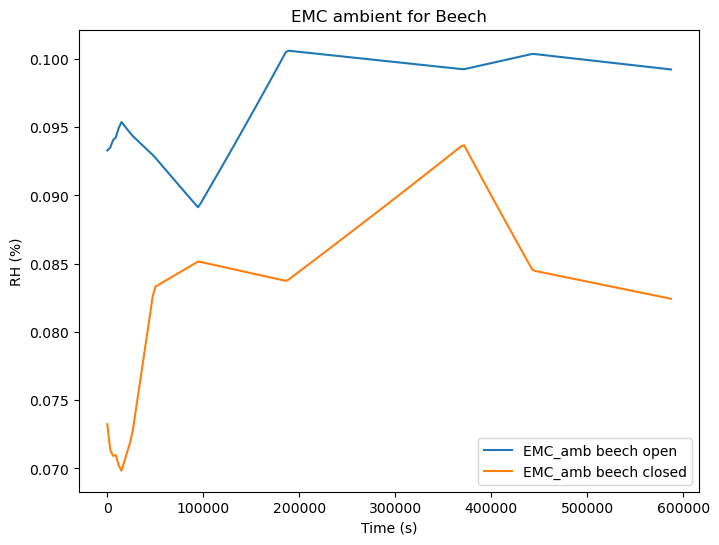

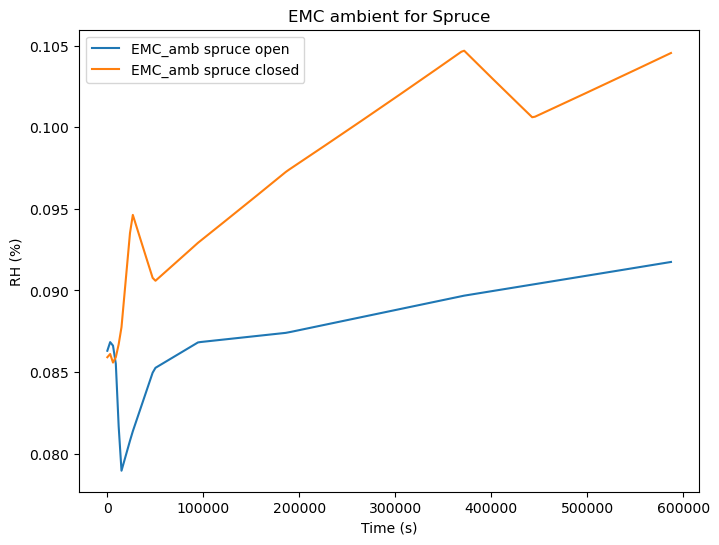

{'beech_open': 0.09788125207693195, 'beech_closed': 0.08520597686280162, 'spruce_open': 0.08845457489985754, 'spruce_closed': 0.09902715243991317}


In [17]:
## Relative humidity

for wood in ["beech", "spruce"]:
    plt.figure(figsize=(8,6))  # one figure per wood type
    
    for state in ["open", "closed"]:
        key = f"{wood}_{state}"
        plt.plot(EMC_amb[key]["Time (s)"], EMC_amb[key]["EMC_amb"], label=f"EMC_amb {key.replace('_', ' ')}")
    
    plt.xlabel("Time (s)")
    plt.ylabel("RH (%)")
    plt.legend()
    plt.title(f"EMC ambient for {wood.capitalize()}")
    plt.show()

EMC_avg = {}  # empty dictionary

for wood in ["beech", "spruce"]:
    for state in ["open", "closed"]:
        key = f"{wood}_{state}"
        EMC_avg[key] = EMC_amb[key]['EMC_amb'].mean()
        
print(EMC_avg)

## SMOOTHED

/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_18858/159933884.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  emc_smooth = emc_smooth.fillna(method='ffill').fillna(method='bfill')


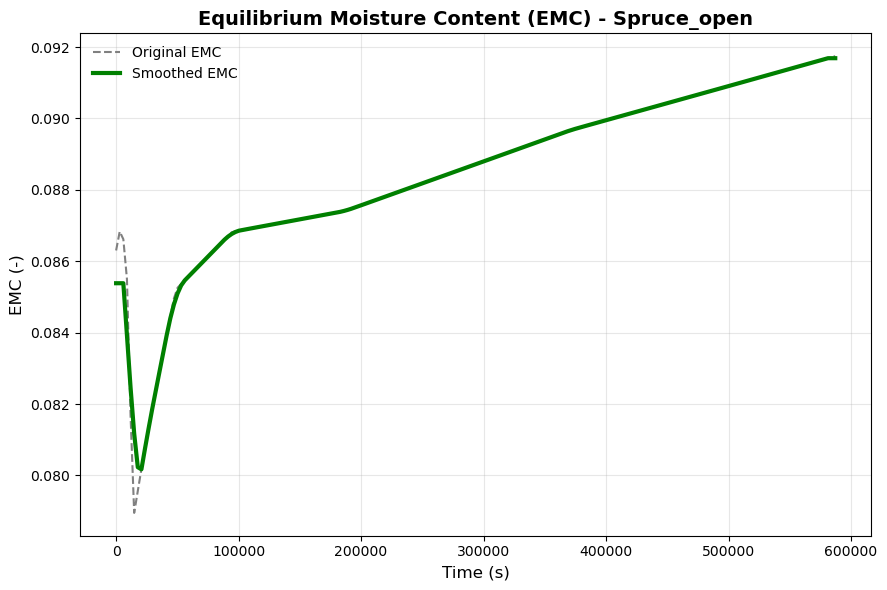

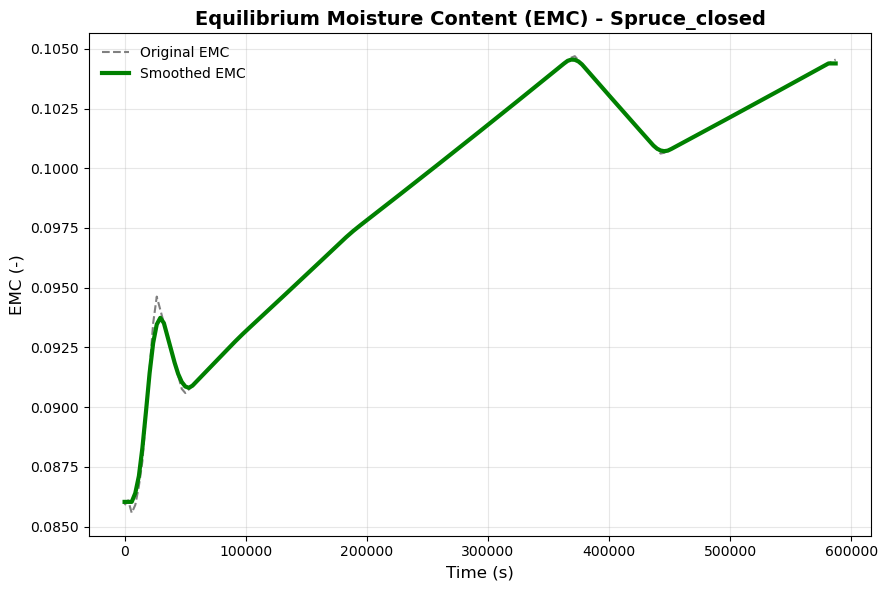

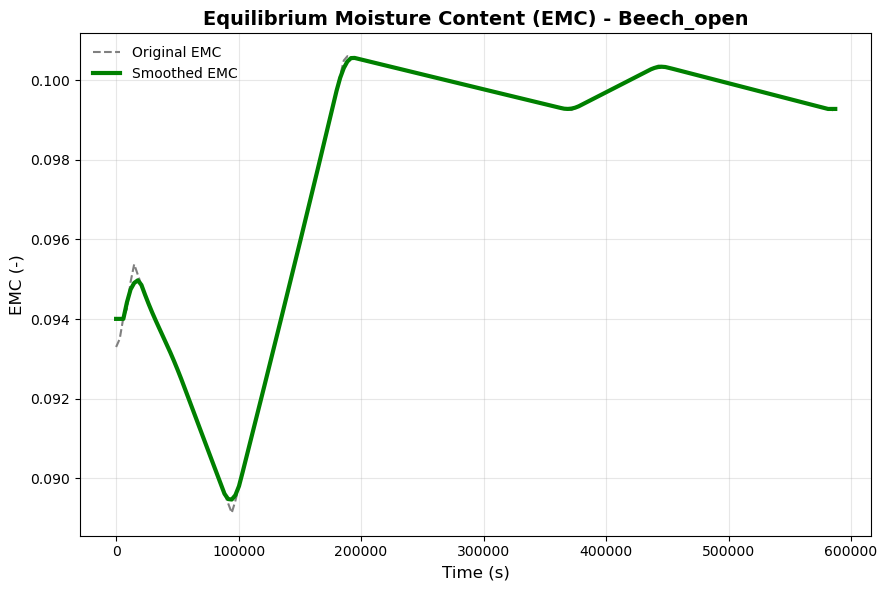

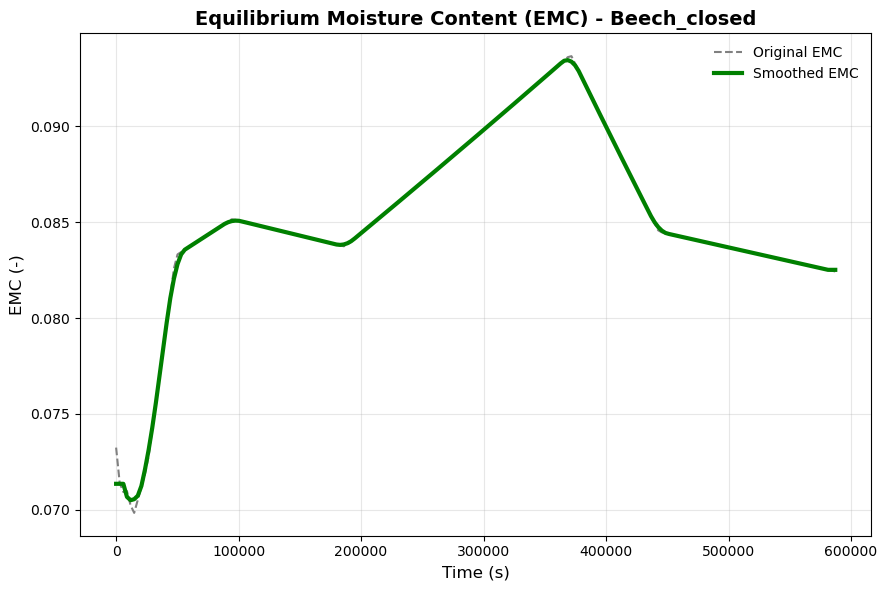

In [31]:
EMC_s = {}
N = 5  # smoothing window

for key, df in EMC_amb.items():
    df = df.copy()  # work on a copy
    
    # Smooth EMC_amb using moving average
    emc_smooth = df['EMC_amb'].rolling(window=N, center=True).mean()
    
    # Fill NaN at edges
    emc_smooth = emc_smooth.fillna(method='ffill').fillna(method='bfill')
    
    # Store results in a DataFrame
    emc_s_df = pd.DataFrame({
        "Time (s)": df["Time (s)"],
        "EMC_amb_smooth": emc_smooth
    })
    
    EMC_s[key] = emc_s_df  # save in dictionary

for key in ["spruce_open", "spruce_closed","beech_open","beech_closed"]:
    # Original and smoothed data
    df_orig = EMC_amb[key]
    df_smooth = EMC_s[key]
    
    plt.figure(figsize=(9,6))
    
    # Plot original EMC
    plt.plot(df_orig["Time (s)"], df_orig["EMC_amb"], 
             color="gray", linewidth=1.5, linestyle="--", label="Original EMC")
    
    # Plot smoothed EMC
    plt.plot(df_smooth["Time (s)"], df_smooth["EMC_amb_smooth"], 
             color="blue" if key=="spruce" else "green", linewidth=3, linestyle="-", label="Smoothed EMC")
    
    # Labels and styling
    plt.title(f"Equilibrium Moisture Content (EMC) - {key.capitalize()}", fontsize=14, fontweight="bold")
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("EMC (-)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(frameon=False, fontsize=10)
    plt.tight_layout()
    plt.show()

In [19]:
for wood in ["beech", "spruce"]:
    for state in ["open", "closed"]:
        key = f"{wood}_{state}"
        EMC_s[key].to_csv (f'EMC_s{key}.csv',index=False)


## Density for input
Density as function of moisture (EMC)

In [ ]:
#density of reference list
dens = pd.DataFrame()

for i in range(1, 6):  # for samples 2 to 5
    mass_col = f"m{i} (g)"
    dens[mass_col] = (ref[mass_col] / 1000) / (0.02 * 0.02 * 0.3)

# use the last density of m2 sample as reference for rho_0 - input in comsol
rho_refm2 = dens['m2 (g)'].iloc[-1]
rho_refm2

In [ ]:
# density of dry wood [kg/m3] based on literature values
rho_0 = 420 
rho_amb = rho_0*(1+w["EMC_amb"])/(1+0.993*rho_0*w["EMC_amb"])
rho_amb

## Density by the equation with k_av
$$
rho_w = rho_0 * \frac{(1+EMC)}{(1 + k_{av} * EMC)}
$$


In [ ]:
# for m2 sample
k_av = 0.5
#rho_0m2 = rho_refm2/1.17105
# zkontrolovat zavorky
rho_0m2 = rho_refm2*(1+k_av*0.11)/(1+0.11)
rho_0m2

In [ ]:
rho_amb2 = pd.DataFrame ()
rho_amb2 ["Time (min)"] = w ["Time (min)"]
rho_amb2 ["rho_amb"] = rho_0m2*(1+w["EMC_amb"])/(1+k_av*w["EMC_amb"])
rho_amb2

In [ ]:
rho_amb2.to_csv("rho_amb.csv", index=False)

In [ ]:
#dens_mer = pd.DataFrame()

#for i in range(1, 6):  # for samples 2 to 5
#    mass_col = f"m{i} (g)"
#    dens_mer[mass_col] = (m[mass_col].iloc[0] / 1000) / (0.02 * 0.02 * 0.3)

#dens_mer 

# use the last density of m2 sample as reference for rho_0 - input in comsol
#rho_refm2 = dens['m2 (g)'].iloc[-1]
# rho_refm2
k_av = 0.5
dens_mer = {}
rho_0_mer = {}

for i in range(1, 6):
    mass_col = f"m{i} (g)"
    dens_col = f"rho{i} (kg/m3)"
    dens_mer[dens_col] = (m[mass_col].iloc[0] / 1000) / (0.02 * 0.02 * 0.3)
    rho_0_mer[dens_col]  = dens_mer[dens_col]*(1+k_av*0.09)/(1+0.09)

dens_mer = pd.Series(dens_mer)
rho_0_mer = pd.Series (rho_0_mer)

print(dens_mer)
print (rho_0_mer)